# Random Matrix Discriminant 

Python implementation of the [Random Matrix Discriminant](https://www.pnas.org/content/116/9/3373) using different molecular descriptors. Code adapted from the initial [MatLab implementation](https://github.com/alphaleegroup/RandomMatrixDiscriminant).

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem, PandasTools, Descriptors 

from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from scipy.integrate import trapz
import random
import pickle

In [2]:
def get_rmd(actives_pd, inactives_pd, des, f_name):
    
    # get array of descriptors
    actives = np.array(list(actives_pd[des]))
    inactives = np.array(list(inactives_pd[des]))
    
    training_binding, verification_binding = train_test_split(actives, test_size=0.1, train_size=0.9)
    training_decoy, verification_decoy = train_test_split(inactives, test_size=0.1, train_size=0.9)
    
    ##processing the training_binding set
    tset_cleaned = training_binding #create a copy of the training_binding set

    ##calculating the z-score
    tset_cleaned_z = stats.zscore(tset_cleaned) #compute the z-score
    sigma = np.std(tset_cleaned, axis = 0) #get the SD for each column
    mu = np.mean(tset_cleaned, axis = 0) #get the mean for each column
    indzero_bind = np.where(sigma==0) #get the positions where SD = 0 returns a tuple containing two arrays
    indzero_bind = list(indzero_bind[0]) #select the array of position indices

    tset_cleaned_z = np.delete(tset_cleaned_z, indzero_bind, axis=1)
    mu_cleaned = np.delete(mu, indzero_bind, axis=0)
    sigma_cleaned = np.delete(sigma, indzero_bind, axis=0)

    ##get the covariance matrix and eigenvalues
    tp_tset_z = tset_cleaned_z.transpose() 
    covariance_matrix = (np.matmul(tp_tset_z, tset_cleaned_z))/tset_cleaned_z.shape[0]
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix) #this is a symmetric matrix so use eigh not eig
    diag = np.diag(eigenvalues) #diagonalise the eigenvalue matrix 

    #Use the Marchenko–Pastur distribution  to get the number of significant eigenvalues
    no_cols = tset_cleaned.shape[1]
    no_rows = tset_cleaned.shape[0]
    no_diag = np.diagonal(diag)
    num_eig = np.size(np.argwhere(no_diag>((1+sqrt(no_cols/no_rows))**2)))

    #get significant eigenvectors
    end = eigenvectors.shape[1]
    sig_vectors = eigenvectors[:,end-num_eig:end] #all rows, columns from end-num_eig to end of eigenvectors
    
    ##processing the training_decoy set
    tset_d_cleaned = training_decoy #create a copy of the training_binding set

    ##calculating the z-score
    tset_d_cleaned_z = stats.zscore(tset_d_cleaned) #compute the z-score
    sigma_d = np.std(tset_d_cleaned, axis = 0) #get the SD for each column
    mu_d = np.mean(tset_d_cleaned, axis = 0) #get the mean for each column
    indzero_bind_d = np.where(sigma_d==0) #get the positions where SD = 0 returns a tuple containing two arrays
    indzero_bind_d = list(indzero_bind_d[0]) #select the array of position indices

    tset_d_cleaned_z = np.delete(tset_d_cleaned_z, indzero_bind_d, axis=1)
    mu_d_cleaned = np.delete(mu_d, indzero_bind_d, axis=0)
    sigma_d_cleaned = np.delete(sigma_d, indzero_bind_d, axis=0)

    ##get the covariance matrix and eigenvalues
    tp_d_tset_z = tset_d_cleaned_z.transpose() 
    covariance_matrix_d = (np.matmul(tp_d_tset_z, tset_d_cleaned_z))/tset_d_cleaned_z.shape[0]
    eigenvalues_d, eigenvectors_d = np.linalg.eigh(covariance_matrix_d) #this is a symmetric matrix so use eigh not eig
    diag_d = np.diag(eigenvalues_d) #diagonalise the eigenvalue matrix 

    #Use the Marchenko–Pastur distribution  to get the number of significant eigenvalues
    #based on his comments i'm assuming this is some approximation to equation 2 in the paper
    no_cols_d = tset_d_cleaned.shape[1]
    no_rows_d = tset_d_cleaned.shape[0]
    no_diag_d = np.diagonal(diag_d)
    num_eig_d = np.size(np.argwhere(no_diag_d>((1+sqrt(no_cols_d/no_rows_d)**2))))

    #get significant eigenvectors
    end_d = eigenvectors_d.shape[1]
    sig_vectors_d = eigenvectors_d[:,end_d-num_eig_d:end_d] #all rows, columns from end-num_eig to end of eigenvectors
    
    ##processing the verification binding set
    verification_binding1 = verification_binding
    verification_binding2 = verification_binding

    #compare the binding verification set to the training decoy + binding sets
    verification_binding1 = np.delete(verification_binding1, indzero_bind, axis = 1) 
    verification_binding2 = np.delete(verification_binding2, indzero_bind_d, axis = 1)

    #mean centre and scale the verification set w.r.t the active training set 

    axis = verification_binding1.shape[0]
    veriset_mu = (verification_binding1-np.tile(mu_cleaned,(axis,1)))/np.tile(sigma_cleaned,(axis,1))
    coeff = np.matmul(veriset_mu,sig_vectors)

    #project back into the ligand space
    proj_vect = np.transpose(np.matmul(sig_vectors,np.transpose(coeff)))
    norm_test = np.sqrt(np.sum(np.power((proj_vect-veriset_mu),2),axis=1))

    #mean centre and scale the verification set w.r.t the decoy training set 

    axis_neg = verification_binding2.shape[0]
    veriset_mu_neg = (verification_binding2-np.tile(mu_d_cleaned,(axis_neg,1)))/np.tile(sigma_d_cleaned,(axis_neg,1))
    coeff_neg = np.matmul(veriset_mu_neg,sig_vectors_d)

    #project back into the ligand space
    proj_vect_neg = np.transpose(np.matmul(sig_vectors_d,np.transpose(coeff_neg)))
    norm_test_neg = np.sqrt(np.sum(np.power((proj_vect_neg-veriset_mu_neg),2),axis=1))
    
    ##processing the verification binding set
    verification_decoy1 = verification_decoy
    verification_decoy2 = verification_decoy

    #compare the binding verification set to the training decoy + binding sets
    verification_decoy1 = np.delete(verification_decoy1, indzero_bind, axis = 1)
    verification_decoy2 = np.delete(verification_decoy2, indzero_bind_d, axis = 1)

    #mean centre and scale the verification set w.r.t the active training set 

    axis = verification_decoy1.shape[0]
    veriset_mu_d = (verification_decoy1-np.tile(mu_cleaned,(axis,1)))/np.tile(sigma_cleaned,(axis,1))
    coeff_d = np.matmul(veriset_mu_d,sig_vectors)

    #project back into the ligand space
    proj_vect_d = np.transpose(np.matmul(sig_vectors,np.transpose(coeff_d)))
    norm_test_d = np.sqrt(np.sum(np.power((proj_vect_d-veriset_mu_d),2),axis=1))

    #mean centre and scale the verification set w.r.t the decoy training set 

    axis_neg = verification_decoy2.shape[0]
    veriset_mu_d_neg = (verification_decoy2-np.tile(mu_d_cleaned,(axis_neg,1)))/np.tile(sigma_d_cleaned,(axis_neg,1))
    coeff_d_neg = np.matmul(veriset_mu_d_neg,sig_vectors_d)

    #project back into the ligand space
    proj_vect_d_neg = np.transpose(np.matmul(sig_vectors_d,np.transpose(coeff_d_neg)))
    norm_test_d_neg = np.sqrt(np.sum(np.power((proj_vect_d_neg-veriset_mu_d_neg),2),axis=1))
    
    #generate a range over which to investigate the AUC, specified in the original paper as using the value thres = 100
    #note changing to 50 and 200 doesnt really change the AUC value obtained in this case!
    thres = 100
    threshold = np.linspace(-thres, thres, num=20000)
    threshold = np.around(threshold, decimals = 2)
    true_pos, false_pos = [], []

    #compute the true and false positives

    #this section is equation 3 in the paper
    for i in range(len(threshold)):
        positions = (np.where(norm_test < (norm_test_neg + threshold[i])))
        positions = np.array(positions[0])
        current = (positions.size)/(norm_test.size)
        true_pos.append(current)
        positions_false = (np.where(norm_test_d < (norm_test_d_neg + threshold[i])))
        positions_false = np.array(positions_false[0])
        current_false = (positions_false.size)/(norm_test_d.size)
        false_pos.append(current_false) #this is fine left as a list!
        
    AUC = round(trapz(true_pos, false_pos), 3)
    
    fig, ax = plt.subplots(1, figsize=(3, 3), dpi=300)
    
    lab = "AUC = " + str(AUC)
    plt.plot(false_pos, true_pos, label=lab) #plot accurate description 
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_aspect('equal', 'box')
    plt.legend(loc='lower right')
    
    #save figure
    plt.tight_layout()
    plt.savefig(f_name, dpi=300, bbox_inches = "tight")

In [3]:
with open('5ht2b_active.pickle', 'rb') as handle:
    actives_pd = pickle.load(handle)

In [7]:
with open('5ht2b_inactive.pickle', 'rb') as handle:
    inactives_pd = pickle.load(handle)

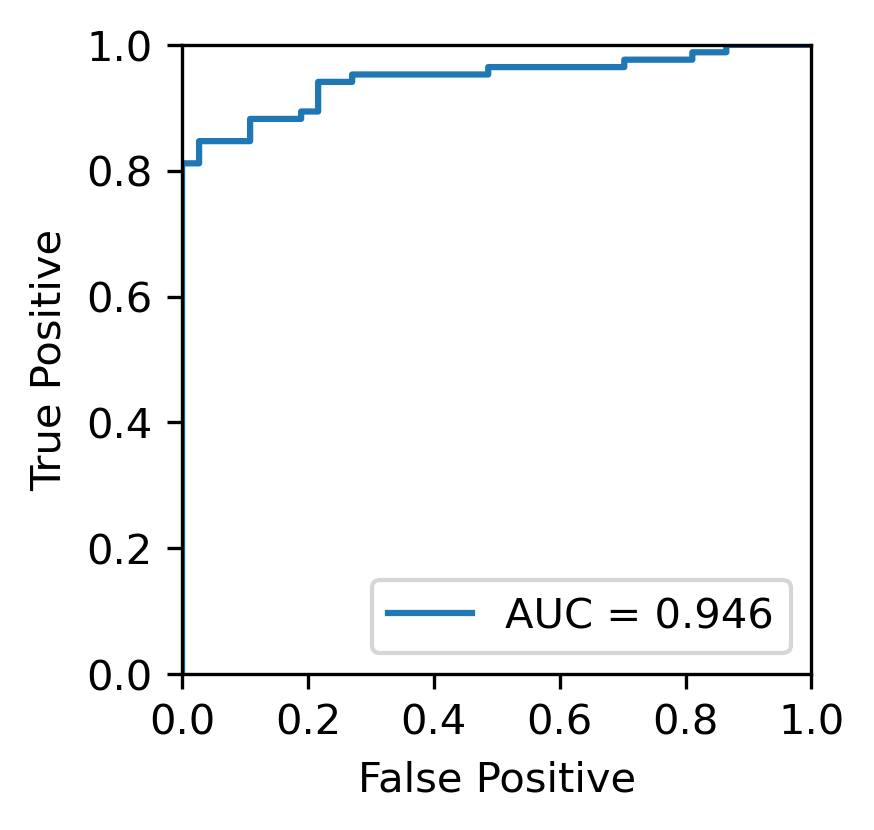

In [9]:
# 2d
get_rmd(actives_pd, inactives_pd, '2D', '5ht2b_2d.png')

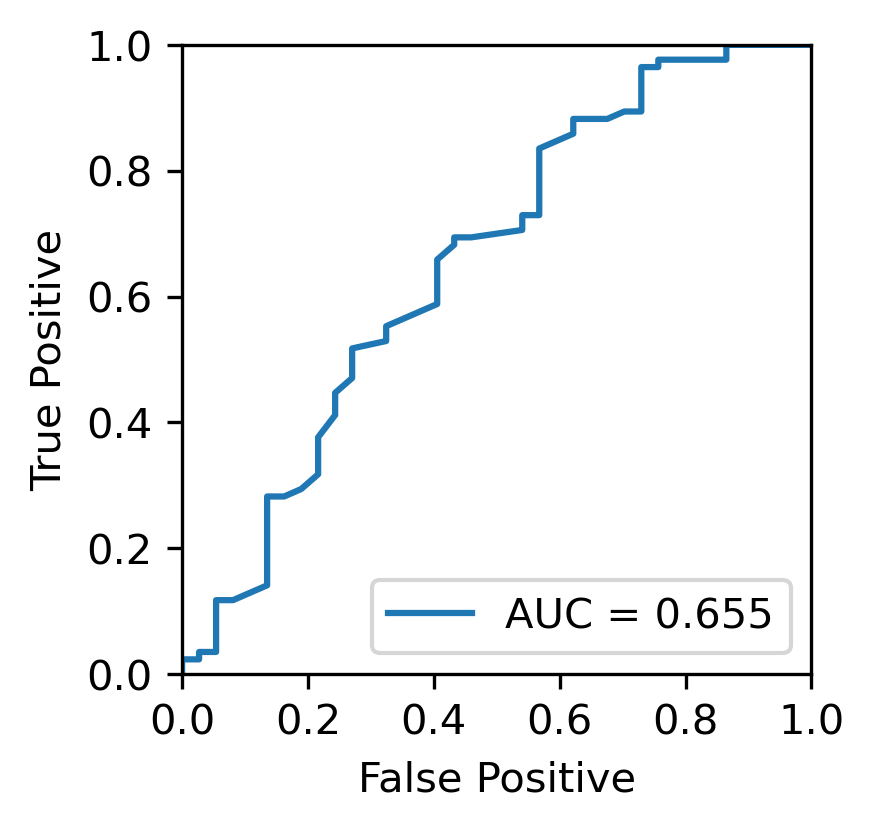

In [10]:
# 3d
get_rmd(actives_pd, inactives_pd, '3D', '5ht2b_3d.png')

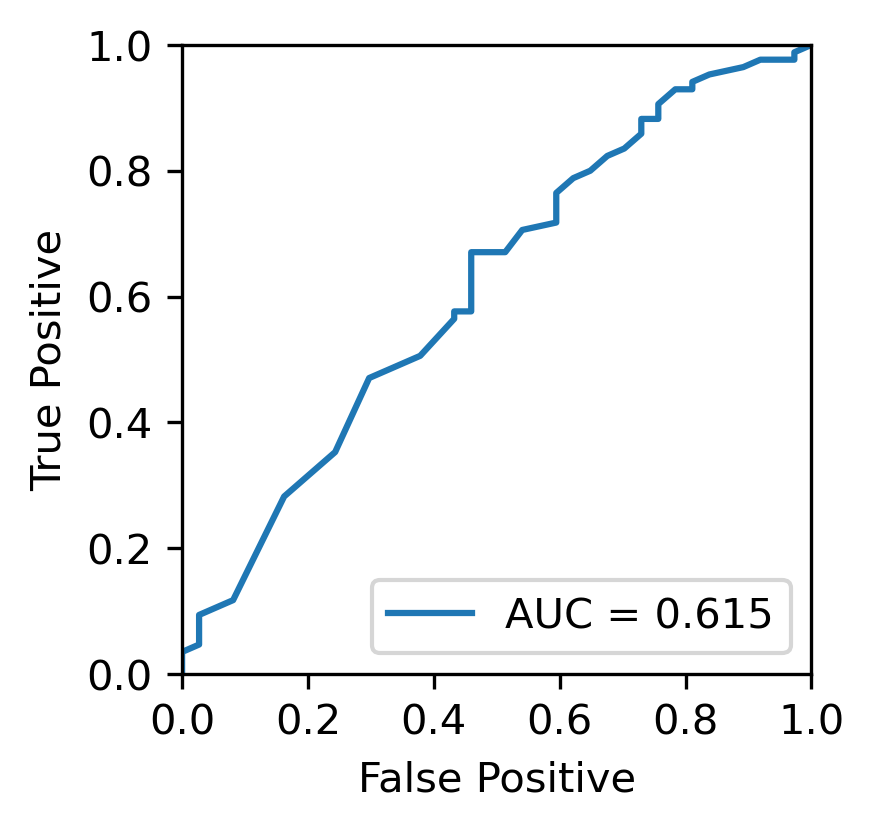

In [11]:
# 3d norm
get_rmd(actives_pd, inactives_pd, 'norm_3D', '5ht2b_3dnorm.png')

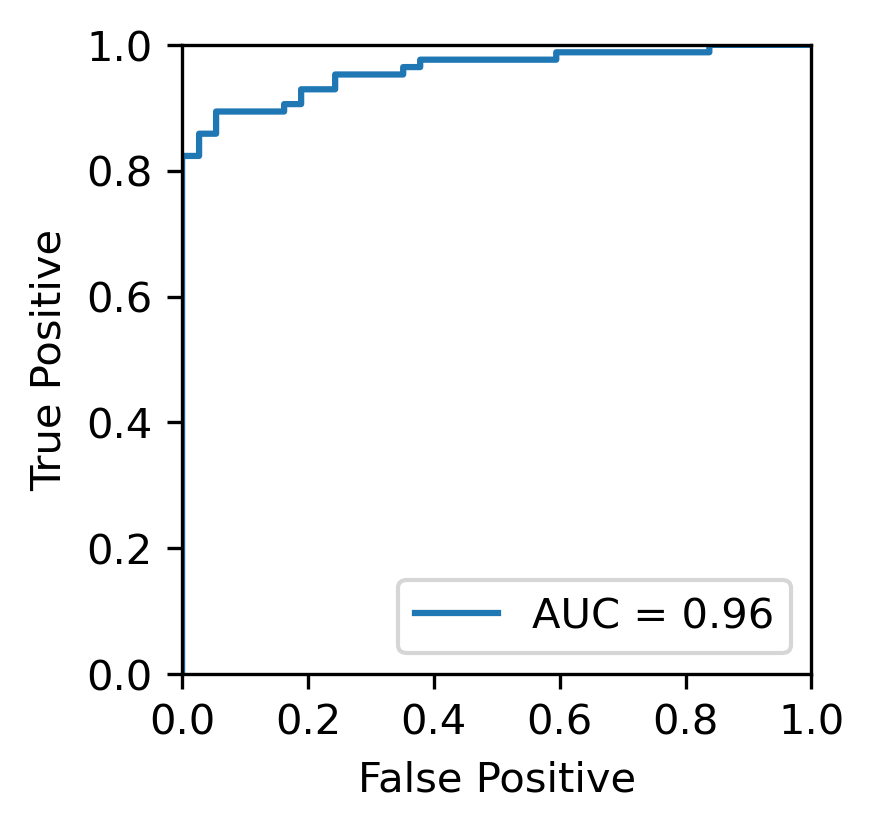

In [12]:
# hybrid
fingerprint_act = list(actives_pd['2D'])
rgmolsa_act = list(actives_pd['norm_3D'])

hybrid_active = [list(fingerprint_act[i]) + rgmolsa_act[i] for i in range(len(fingerprint_act))]

actives_pd['hybrid'] = hybrid_active

fingerprint_inact = list(inactives_pd['2D'])
rgmolsa_inact = list(inactives_pd['norm_3D'])

hybrid_inactive = [list(fingerprint_inact[i]) + rgmolsa_inact[i] for i in range(len(fingerprint_inact))]

inactives_pd['hybrid'] = hybrid_inactive

get_rmd(actives_pd, inactives_pd, 'hybrid', '5ht2b_hybrid.png')